In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy.ma as ma
import glob
from collections import namedtuple, OrderedDict
import netCDF4 as nc
import os
import scipy
import scipy.io as sio
from scipy import interpolate, signal
from pyproj import Proj,transform
import sys
sys.path.append('/ocean/ssahu/CANYONS/wcvi/grid/')
from bathy_common import *
from matplotlib import path
from salishsea_tools import viz_tools
import xarray as xr
from salishsea_tools import nc_tools
import scipy.io as sio
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import cmocean as cmo
import matplotlib.gridspec as gridspec
%matplotlib inline
from scipy.io import loadmat
from scipy.interpolate import griddata
from dateutil.parser import parse
from salishsea_tools import geo_tools, viz_tools, tidetools, nc_tools
import gsw
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Ellipse
import matplotlib as mpl

import seaborn as sns
from windrose import plot_windrose
from windrose import WindroseAxes


from dateutil        import parser
from datetime import datetime

import numpy.ma as ma

sns.set_context('talk')
sns.set_style('darkgrid')

/home/ssahu/anaconda3/lib/python3.5/site-packages/xarray/conventions.py:9: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


In [2]:
zlevels = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_20140915_00001440_grid_T.nc').variables['deptht'][:32]
y_wcvi_slice = np.array(np.arange(180,350))
x_wcvi_slice = np.array(np.arange(480,650))


bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

Z = bathy.variables['Bathymetry']


lon = bathy['nav_lon'][...]
lat = bathy['nav_lat'][...]



nc_file = nc.Dataset('/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/accurate_isopycnals_eddy_water_particles_two_months_more.nc')
nc_tools.show_variables(nc_file)

odict_keys(['init_x', 'init_y', 'init_z', 'init_t', 'init_age', 'init_transp', 'final_x', 'final_y', 'final_z', 'final_t', 'final_age', 'final_transp', 'traj_lon', 'traj_lat', 'traj_depth', 'traj_time', 'traj_temp', 'traj_salt', 'traj_dens'])


In [3]:


init_x = nc_file.variables['init_x']
init_z = nc_file.variables['init_z']
init_age = nc_file.variables['init_age']

traj_depth = nc_file.variables['traj_depth'][:]
traj_lon   = nc_file.variables['traj_lon'][:]
traj_lat   = nc_file.variables['traj_lat'][:]
traj_rho   = nc_file.variables['traj_dens'][:]
traj_tem   = nc_file.variables['traj_temp'][:]
traj_sal   = nc_file.variables['traj_salt'][:]
traj_time  = nc_file.variables['traj_time']


final_age = nc_file.variables['final_age']


# lon1=nc_file.variables['traj_lon'][:]
# lat1=nc_file.variables['traj_lat'][:]
# dep1=nc_file.variables['traj_depth'][:]
x1=nc_file.variables['init_x'][:]
y1=nc_file.variables['init_y'][:]
t1=nc_file.variables['traj_time'][:]

x_low = x1
y_low = y1

x2=nc_file.variables['final_x'][:]
y2=nc_file.variables['final_y'][:]


final_z = nc_file.variables['final_z'][:]

final_age_days = final_age[:]/(3600)

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type


In [4]:
cross_index_low = np.load(file='/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/numpy_arrays_saved/cross_index_accurate_iso_low_two_more_months.npy')

time_index_low  = np.load(file='/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/numpy_arrays_saved/time_index_accurate_iso_low_two_more_months.npy')

In [17]:
x_200_total_low = np.load(file='/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/numpy_arrays_saved/\
x_200_total_eddy_water_acc_iso_two_more_months.npy')

y_200_total_low  = np.load(file='/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/numpy_arrays_saved/\
y_200_total_eddy_water_acc_iso_iso_two_more_months.npy')

In [7]:
def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins)
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False )

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter(x, y, c=z, **kwargs)
    return ax

In [12]:
zlevels = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_20140915_00001440_grid_T.nc').variables['deptht'][:32]
y_wcvi_slice = np.array(np.arange(180,350))
x_wcvi_slice = np.array(np.arange(480,650))


bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

Z = bathy.variables['Bathymetry']


lon = bathy['nav_lon'][...]
lat = bathy['nav_lat'][...]



nc_file = nc.Dataset('/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/\
accurate_isopycnals_south_outer_shelf__water_particles_two_months_more.nc')

In [13]:


init_x = nc_file.variables['init_x']
init_z = nc_file.variables['init_z']
init_age = nc_file.variables['init_age']

traj_depth = nc_file.variables['traj_depth'][:]
traj_lon   = nc_file.variables['traj_lon'][:]
traj_lat   = nc_file.variables['traj_lat'][:]
traj_rho   = nc_file.variables['traj_dens'][:]
traj_tem   = nc_file.variables['traj_temp'][:]
traj_sal   = nc_file.variables['traj_salt'][:]
traj_time  = nc_file.variables['traj_time']


final_age = nc_file.variables['final_age']


# lon1=nc_file.variables['traj_lon'][:]
# lat1=nc_file.variables['traj_lat'][:]
# dep1=nc_file.variables['traj_depth'][:]
x1=nc_file.variables['init_x'][:]
y1=nc_file.variables['init_y'][:]
t1=nc_file.variables['traj_time'][:]

x_high = x1
y_high = y1

x2=nc_file.variables['final_x'][:]
y2=nc_file.variables['final_y'][:]


final_z = nc_file.variables['final_z'][:]

final_age_days = final_age[:]/(3600)

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type


In [14]:
cross_index_high = np.load(file='/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/\
numpy_arrays_saved/cross_index_accurate_iso_high_two_more_months.npy')

time_index_high = np.load(file='/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/numpy_arrays_saved/\
time_index_accurate_iso_high_two_more_months.npy')

In [16]:
x_200_total_high = np.load(file='/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/numpy_arrays_saved/\
x_200_south_outer_shelf_water_acc_iso_two_more_months.npy')

y_200_total_high  = np.load(file='/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/numpy_arrays_saved/\
y_200_south_outer_shelf_water_acc_iso_two_more_months.npy')

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


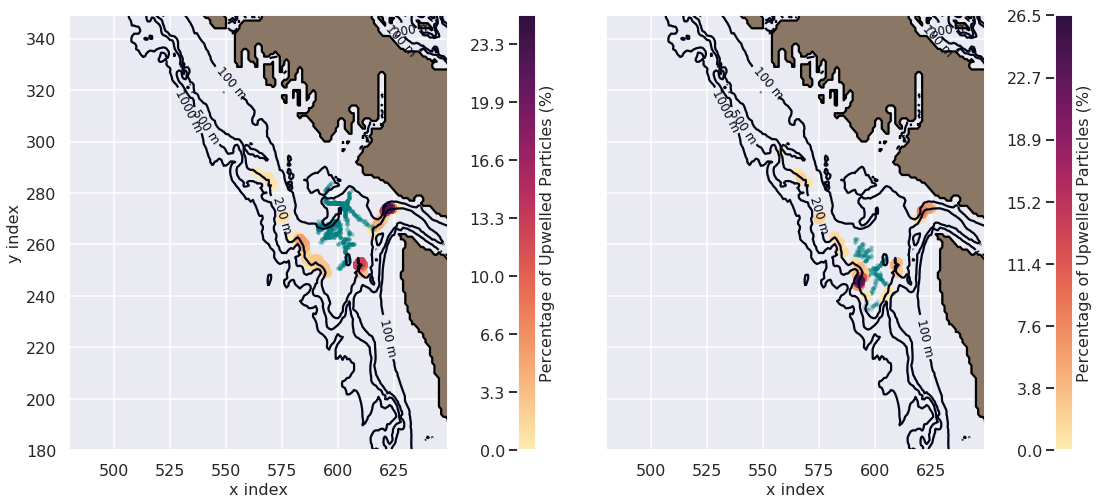

In [82]:
from scipy.interpolate import interpn
from mpl_toolkits.axes_grid1 import make_axes_locatable





cmap = plt.get_cmap(cmo.cm.matter)


bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

Z = bathy.variables['Bathymetry']


lon = bathy['nav_lon'][...]
lat = bathy['nav_lat'][...]




# cmap=plt.cm.get_cmap('nipy_spectral')
# cmap = plt.cm.get_cmap('gist_rainbow_r')
cmap.set_bad('#8b7765')
vmin = 0
vmax = 150

import matplotlib as mpl

gridspec = {'width_ratios': [2, 0.1, 2, 0.1], 'wspace':0.35, 'hspace':0}

fig, ax = plt.subplots(1, 4, figsize=(18, 8), gridspec_kw=gridspec)


# fig, (ax1,ax) = plt.subplots(1, 2, figsize=(12,8), sharey=True); 

ax[0].grid()

CS1 = ax[0].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,110,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)


CS1 = ax[0].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(200,210,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = ax[0].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(1000,1010,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = ax[0].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(500,510,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)



ax[0].set_xlabel('x index', fontsize =16)
ax[0].set_ylabel('y index', fontsize = 16)
ax[0].tick_params(axis='both',labelsize =16)

ax[0].legend(loc = 'best')

viz_tools.plot_land_mask(ax[0], bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='#8b7765')
viz_tools.plot_coastline(ax[0], bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='k')


lon_LB08 = -125.4775
lat_LB08 = 48.4217

j, i = geo_tools.find_closest_model_point(lon_LB08,lat_LB08,\
                                          lon,lat,grid='NEMO',tols=\
                                          {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                           'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}}) 


q = density_scatter(x_200_total_low[~np.isnan(y_200_total_low)], y_200_total_low[~np.isnan(y_200_total_low)], ax= ax[0], bins = [30,30], cmap = cmap , \
                    vmin = vmin, vmax = vmax)

ax[0].grid()


m = cm.ScalarMappable(cmap=cmap)
m.set_array(q)
m.set_clim(vmin,vmax)
# plt.colorbar(m, cax=ax[2])

cbar = fig.colorbar(m, cax=ax[1])#, format=ticker.FuncFormatter(fmt))


cbar.ax.set_yticklabels(np.around(a=np.linspace(start=(cbar.vmin/cross_index_low.shape[0])*100, \
                                    stop=(cbar.vmax/cross_index_low.shape[0])*100, num=8), decimals = 1))

cbar.set_label(label='Percentage of Upwelled Particles (%)', fontsize = 16)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.tick_left()

po = ax[0].scatter(x_wcvi_slice[(x_low[:]-1).astype(int)],y_wcvi_slice[(y_low[:]-1).astype(int)], marker = '*', c = 'teal', s = 2, alpha = 0.2, linewidths=3)


# Line = ax[0].plot(x_200_wcvi[::1], y_200_wcvi[::1], 'k-')

vmin = 0
vmax = 35


ax[2].grid()


CS1 = ax[2].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,110,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = ax[2].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(200,210,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = ax[2].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(1000,1010,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = ax[2].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(500,510,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)




ax[2].set_xlabel('x index', fontsize =16)
# ax.set_ylabel('y index', fontsize = 16)
ax[2].tick_params(axis='both',labelsize =16)
ax[2].get_yaxis().set_ticklabels([])



ax[2].legend(loc = 'best')

viz_tools.plot_land_mask(ax[2], bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='#8b7765')
viz_tools.plot_coastline(ax[2], bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='k')



# ax.vlines(x = 635, ymin = 261, ymax = 279, color = 'blue')

# ax.get_legend().remove()
lon_LB08 = -125.4775
lat_LB08 = 48.4217

j, i = geo_tools.find_closest_model_point(lon_LB08,lat_LB08,\
                                          lon,lat,grid='NEMO',tols=\
                                          {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                           'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}}) 
po = ax[2].scatter(x_wcvi_slice[(x_high[:]-1).astype(int)],y_wcvi_slice[(y_high[:]-1).astype(int)], marker = '*', c = 'teal', s = 2, alpha = 0.2, linewidths=3)


q = density_scatter(x_200_total_high[~np.isnan(y_200_total_high)], y_200_total_high[~np.isnan(y_200_total_high)], ax= ax[2], bins = [30,30], cmap = cmap , vmin = vmin, vmax = vmax)

ax[2].grid()


# Line = ax[1].plot(x_200_wcvi[::1], y_200_wcvi[::1], 'm-')


m = cm.ScalarMappable(cmap=cmap)
m.set_array(q)
m.set_clim(vmin,vmax)
# plt.colorbar(m, cax=ax[2])

cbar = fig.colorbar(m, cax=ax[3])#, format=ticker.FuncFormatter(fmt))


cbar.ax.set_yticklabels(np.around(a=np.linspace(start=(cbar.vmin/cross_index_high.shape[0])*100, \
                                    stop=(cbar.vmax/cross_index_high.shape[0])*100, num=8), decimals = 1))

cbar.set_label(label='Percentage of Upwelled Particles (%)', fontsize = 16)
cbar.ax.tick_params(labelsize=16)

cbar.ax.yaxis.tick_left()
# fig.tight_layout(h_pad=0.1,w_pad=0.1)

